New notebook showing what was done to ingest the SDSS parquet files, and cross-matching this table (which contains only stars) to ZTF DR7 table. 

In [1]:
%load_ext autoreload
%autoreload 2

# Start spark session

In [2]:
# settings to do the ingest 
# Explanation of local[N] https://stackoverflow.com/questions/32356143/what-does-setmaster-local-mean-in-spark 

# Eric's settings from ZTF 
# https://github.com/dirac-institute/ztf_axs_import/blob/main/notebooks/ztf_dr7.ipynb 
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .config('spark.master', "local[20]") # 20 when running the full crossmatch, 10 when doing validation.
         .config('spark.driver.memory', '80G')
         .config("spark.sql.execution.arrow.enabled", "true")
         # uncomment if beta-jupyterhub proxies are working again.  otherwise, tunnel
         #.config("spark.ui.proxyBase", "https://epyc.astro.washington.edu/beta-jupyter/user/ecbellm/proxy/4040")
         .config("spark.port.maxRetries", "128")
         .enableHiveSupport()
         .getOrCreate())
spark


# Create the AXS 'sdss' table from parquet files 

Note - run only once! This takes all parquet files from `/epyc/data/sdss_parquet/sdss_star_`, and merges them into one `sdss` table. 

In [ ]:
from axs.catalog import AxsCatalog

catalog = AxsCatalog(spark)
parqDF = spark_session.read.parquet('/epyc/data/sdss_parquet/sdss_star_*')
# started at 10:31 am PDT, Oct 20th  
# finished at 10:46 am PDT 
catalog.save_axs_table(parqDF.withColumnRenamed("RA","ra").\
                       withColumnRenamed("DEC","dec"), "sdss",  True, True, 500 ) 

The resulting table contains 509,390,705 rows. 

# Inspect the SDSS table in AXS

In [8]:
from axs.catalog import AxsCatalog
catalog = AxsCatalog(spark)


In [27]:
catalog.list_table_names()

['gaia_dr2_1am_dup',
 'allwise_1am_dup',
 'unwise_v1',
 'cklein_flare',
 'unwise_v2',
 'catalina_variables_n',
 'gaia',
 'gaia_dr2_1am_dup_ssd',
 'ps1',
 'green19_stellar_params',
 'rosat_2rxs',
 'rosat_2rxs_z4am_b2am',
 'ztf_dr3_2rxs_obj',
 'wtf_ztf_dr3',
 'ztf_wds_kjb_dr3',
 'karenws_cut_wtf_fits_r_band',
 'karenws_cut_wtf_fits',
 'ztf_aug2020_2rxs_obj',
 'skymapper_dr2',
 'test_skymapper',
 'skymapper_dr2_ver2',
 'skymapper_dr2_ver3',
 'ztf_rrlyr',
 'gaia_source_edr3',
 'gaia_edr3_distances',
 'rrlyrae_sample_andy',
 'stevengs_test_small_df',
 'ztf5',
 'feh_rrlyr_ab_020620',
 'kepler_rrlyrae',
 'ztf_kepler_rrlyrae',
 'ps_uband',
 'ps_uband_ver2',
 'debug_match_a',
 'debug_match_b',
 'debug_match_c',
 'ztf_rrlyr_grid_50',
 'igaps_halpha_emitters',
 'wtf_aug2020_asymmetric_2',
 'wtf_aug2020_asymmetric_3',
 'wtf_aug2020_dip_candidates',
 'ztf_rr_lyrae_preprocessed_and_gridded_09_01_2021',
 'ztf_rr_lyrae_phi_31_fits_09_01_2021',
 'stevengs_test_sources',
 'ddf_sources_bigger',
 'ztf_dr7

Note  : the OBJC_TYPE corresponds to 
http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=enum+PhotoType+E  (S.Anderson, priv.comm.)

There is no specific documentation for this table that I could find. Probably ext =  PSF - aperture  (flux units) (C.Slater, priv.comm.) 


Plot one million stars . Select stars by requiring OBJC_TYPE == 6 . We also ensure that we are only using nonnegative fluxes. All that is achieved by SQL-like syntax of `.select()` (choosing columns of interest), and `.where()` (making selection). 

Ideally  should be only one `.where()` statement (according to C.Slater) with combined requirements - another `.where()` indicates a constraint on what was selected by the preceding `.where()` statement. 


The `.limit()` and `.toPandas()` limit the number of rows passed by `.select()` (here to 1 mln) and transform axs catalog to Pandas DataFrame.  If needed, this can be turned to AstroPy table with  `Table.from_pandas()` method on AstroPy Table. 



In [9]:
sdss = catalog.load("sdss")

In [10]:
sdss.count()

509390705

Confirm that there are no galaxies:

In [17]:
sub = sdss.select(['zone', 'u','g','r','OBJC_TYPE', 'obj_type',
                    'uExt', 'gExt']).\
    where(sdss['OBJC_TYPE'] == 3)
sub.count()

0

Check that there are only stars:

In [18]:
sub = sdss.select(['zone', 'u','g','r','OBJC_TYPE', 'obj_type',
                    'uExt', 'gExt']).\
    where(sdss['OBJC_TYPE'] == 6)
sub.count()

509390705

This is the same as the total count so we are certain all elements of the table are stars only. 

In [23]:
import numpy as np
import matplotlib.pyplot as plt 

# select only galaxies,  
# ensure non-negative fluxes ...
sdsst = sdss.select(['zone', 'u','g','r','OBJC_TYPE', 'obj_type',
                    'uExt', 'gExt']).\
    where(sdss['OBJC_TYPE'] == 6).\
    where((sdss['u'] > 0) &(sdss['g'] > 0)&(sdss['r'] > 0) ).\
    limit(1000000).toPandas()
    
# convert to mags ...
u =  -2.5 * np.log10(sdsst['u']) + 22.5
g =  -2.5 * np.log10(sdsst['g']) + 22.5
r =  -2.5 * np.log10(sdsst['r']) + 22.5

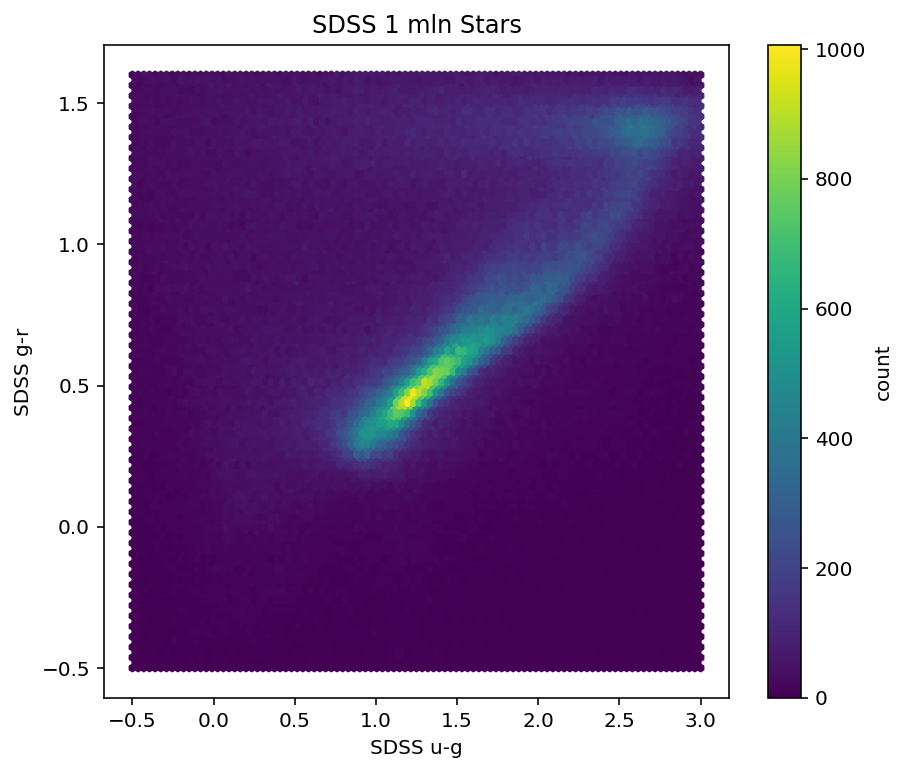

In [26]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
fig,ax = plt.subplots(1,1,figsize=(7,6))
img = ax.hexbin(u-g , g-r , extent=(-0.5,3,-0.5, 1.6))
ax.set_title('SDSS 1 mln Stars')
ax.set_xlabel('SDSS u-g')
ax.set_ylabel('SDSS g-r')
plt.colorbar(img, label='count')

# Crossmatch SDSS to ZTF 

In [ ]:
import pyspark 

# settings to run crossmatch 
spark = pyspark.sql.SparkSession.builder \
    .config('spark.master', "local[8]")\
    .config("spark.driver.memory", "18g") \
    .config("spark.executor.memory", "40g") \
    .config("spark.cores.max", "45") \
    .config("spark.executor.cores", "3") \
    .enableHiveSupport() \
    .getOrCreate()

In [15]:
from axs.catalog import AxsCatalog
catalog = AxsCatalog(spark)
#catalog.list_table_names()

## Load SDSS

In [ ]:
sdss =  catalog.load('sdss')

In [14]:
sdss.head(1)

[Row(index=23120, RUN=6361, CAMCOL=1, FIELD=110, ID=546, OBJC_TYPE=6, OBJC_FLAGS=268567128, OBJC_FLAGS2=24600, ra=5.245964700654099, dec=-16.24928976136709, RESOLVE_STATUS=257, uExt=0.13377264142036438, gExt=0.0984286293387413, rExt=0.07138865441083908, iExt=0.05413185432553291, zExt=0.038380157202482224, u=0.5029231905937195, g=1.460984468460083, r=1.7194849252700806, i=1.6982033252716064, z=2.834886074066162, uErr=16.930564880371094, gErr=75.96382904052734, rErr=39.639251708984375, iErr=20.511323928833008, zErr=1.3242864608764648, uCalib=1, gCalib=1, rCalib=1, iCalib=1, zCalib=1, obj_type=2, obj_index=344091906885, zone=4424, dup=1)]

### Load ZTF

In [ ]:
ztf = catalog.load("ztf_dr7")

In [ ]:
ztf.columns

['ps1_objid',
 'ra',
 'dec',
 'ps1_gMeanPSFMag',
 'ps1_rMeanPSFMag',
 'ps1_iMeanPSFMag',
 'ra_detections',
 'dec_detections',
 'mjd_g',
 'mag_g',
 'magerr_g',
 'catflags_g',
 'rcID_g',
 'fieldID_g',
 'mjd_r',
 'mag_r',
 'magerr_r',
 'catflags_r',
 'rcID_r',
 'fieldID_r',
 'mjd_i',
 'mag_i',
 'magerr_i',
 'catflags_i',
 'rcID_i',
 'fieldID_i',
 'nobs_g',
 'nobs_r',
 'nobs_i',
 'mean_mag_g',
 'mean_mag_r',
 'mean_mag_i',
 'zone',
 'dup']

In [ ]:
ztf_pd = ztf.select(ztf.columns).where(ztf['nobs_r']>0).limit(1000).toPandas()

In [ ]:
ztf_pd[:10]

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,ra_detections,dec_detections,mjd_g,mag_g,...,rcID_i,fieldID_i,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,zone,dup
0,88490000075421199,0.007696,-16.257666,-999.000000,21.776100,21.483801,"[0.007681999821215868, 0.007710999809205532]","[-16.257688522338867, -16.25764274597168]","[58351.4296875, 58677.46484375]","[21.829124450683594, 21.65118980407715]",...,[],[],2,7,0,21.740157,21.073684,None,4424,0
1,88480000290704349,0.029197,-16.263266,20.495399,20.305799,20.159599,"[0.02918500080704689, 0.02920049987733364, 0.0...","[-16.26324462890625, -16.26329803466797, -16.2...","[58323.44140625, 58338.4140625, 58338.4140625,...","[20.537368774414062, 20.732341766357422, 20.26...",...,[],[],82,106,0,20.473658,20.162572,None,4424,0
2,88500000296273063,0.029736,-16.247847,20.997801,19.757401,18.785000,"[0.029754100367426872, 0.029723599553108215, 0...","[-16.24785041809082, -16.247865676879883, -16....","[58320.46484375, 58323.44140625, 58338.4140625...","[21.148662567138672, 20.949527740478516, 21.06...",...,[],[],45,146,0,20.913559,19.550622,None,4424,1
3,88480000310609896,0.031129,-16.258591,-999.000000,-999.000000,21.760900,[0.0311294998973608],[-16.258590698242188],[],[],...,[],[],0,1,0,NaN,20.991730,None,4424,0
4,88480000340043358,0.034099,-16.264190,15.441800,15.074000,14.949400,"[0.034106701612472534, 0.034095000475645065, 0...","[-16.264196395874023, -16.264179229736328, -16...","[58363.3984375, 58772.29296875, 58772.29296875...","[15.426385879516602, 15.480671882629395, 15.47...",...,[],[],162,181,0,15.468940,15.028158,None,4424,0
5,88480000543134170,0.054267,-16.263667,20.695299,19.963900,19.592699,"[0.05426760017871857, 0.054248299449682236, 0....","[-16.26367950439453, -16.263662338256836, -16....","[58320.46484375, 58323.44140625, 58338.4140625...","[20.585039138793945, 20.672672271728516, 20.84...",...,[],[],65,130,0,20.639020,19.816002,None,4424,0
6,88500000542900712,0.054309,-16.249659,21.600599,20.333500,19.714701,"[0.05429830029606819, 0.05429840087890625, 0.0...","[-16.24968147277832, -16.24962615966797, -16.2...","[58370.375, 58374.27734375, 58432.24609375, 59...","[21.380802154541016, 20.622020721435547, 20.81...",...,[],[],5,120,0,21.041157,20.022303,None,4424,1
7,88480000587403327,0.058815,-16.264223,-999.000000,21.332800,20.765200,[0.05881530046463013],[-16.264223098754883],[],[],...,[],[],0,16,0,NaN,21.068029,None,4424,0
8,88490000602422280,0.060415,-16.256705,21.506701,21.612101,21.281601,"[0.0602869987487793, 0.060542598366737366]","[-16.25676918029785, -16.256641387939453]",[58764.37109375],[20.5765323638916],...,[],[],1,27,0,20.576532,20.993951,None,4424,0
9,88490000605822215,0.060543,-16.256641,-999.000000,21.443600,21.399799,[0.060542598366737366],[-16.256641387939453],[],[],...,[],[],0,27,0,NaN,20.993951,None,4424,0


To crossmatch, need to select converting fluxes to magnitudes

In [ ]:
%%time 

from pyspark.sql.functions import log10 as sparklog10
limitMag = 20 
sdss_sel = sdss.select(['zone', 'RA', 'DEC', 'u','g','r','i',
                        'uErr','gErr', 'rErr', 'iErr', 'dup']).\
    where((sdss['OBJC_TYPE'] == 6) & (sdss['u'] > 0) &(sdss['g'] > 0)&(sdss['r'] > 0)&\
    ((-2.5 * sparklog10(sdss['g']) + 22.5) < limitMag))

CPU times: user 8.8 ms, sys: 2.44 ms, total: 11.2 ms
Wall time: 674 ms


In [ ]:
sdss_sel.count()

106331860

With `ztf_dr7` it looks like now there are columns with `mean_mag_g`, `mean_mag_r`, `mean_mag_i` , which is super useful. 

There are also columns which show that objects have been observed in `g` , `r` , or `i` filter.

For now, select only those that had lots of `r` band observations, because those are the ones we want to calculate... 

In [ ]:
%%time
a = ztf.where(ztf['nobs_r']>10).count()
print(a)

1090018569
CPU times: user 31.2 ms, sys: 13.1 ms, total: 44.3 ms
Wall time: 2min 15s


## Crossmatch ZTF to SDSS, selecting on r-band observation number

In [ ]:
%%timeit 
from axs import Constants

limitMag = 20 
limitMagZ = limitMag+2
for fid in 'gri' : 
    
    # select ZTF with the number of observations and 
    # with objects brighter than the SDSS limit + 2 
    # even though its a different filter, 
    # I don't expect there to be a bigger offset
    ztf_fid = ztf.select(ztf.columns).\
    where((ztf[f'nobs_{fid}']>10) & (ztf[f'mean_mag_{fid}']<limitMagZ))
        
    print(f'Crossmatching ZTF {fid} to SDSS stars  g < {limitMag}...')
    fname = f"ztf_{fid}_sdss_stars_g_lt_{limitMag}_2asec"
    
    
    crossmatch = ztf_fid.\
        crossmatch(sdss_sel, r=2*Constants.ONE_ASEC).\
        save_axs_table(fname)
    print('Saving to ', fname)

In [ ]:
%%timeit 
from axs import Constants

limitMag = 20 
limitMagZ = limitMag+1
for fid in 'gri' : 
    
    # select ZTF with the number of observations and 
    # with objects brighter than the SDSS limit + 2 
    # even though its a different filter, 
    # I don't expect there to be a bigger offset
    ztf_fid = ztf.select(ztf.columns).\
    where((ztf[f'nobs_{fid}']>10) & (ztf[f'mean_mag_{fid}']<limitMagZ))
        
    print(f'Crossmatching SDSS  g < {limitMag} to ZTF {fid}  ...')
    fname = f"sdss_ztf_{fid}_2asec"
    
    crossmatch = sdss_sel.\
        crossmatch(ztf_fid, r=2*Constants.ONE_ASEC).\
        save_axs_table(fname)
    print('Saving to ', fname)

## Inspect the result 

In [38]:
sdss_ztfr = catalog.load('ztf_r_sdss_stars_g_lt_20_2asec')

More of that in `ZTF_SDSS_offsets_2022` 

In [39]:
sdss_ztfrt = sdss_ztfr.select(['nobs_r', 'mean_mag_r', 'u','g','r','i','ra','dec']).\
             limit(10000).toPandas()

Convert fluxes to mags

In [40]:
for f in 'ugri':
    sdss_ztfrt[f+'mag'] =  -2.5 * np.log10(sdss_ztfrt[f]) + 22.5

Show offset between ZTF r and SDSS r as a function of SDSS r mag: 

Text(0, 0.5, 'SDSS r  - ZTF mean r')

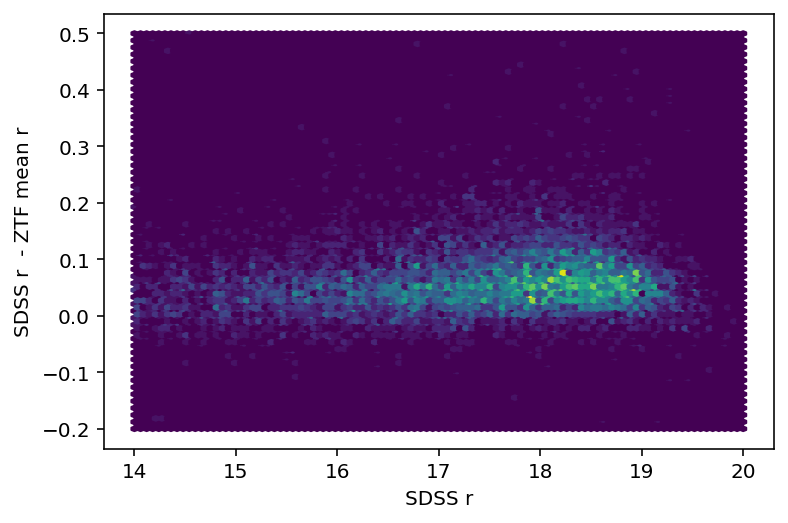

In [42]:
%matplotlib inline
fid = 'r'
plt.hexbin(sdss_ztfrt[f'mean_mag_{fid}'], 
           sdss_ztfrt[f'{fid}mag'] - sdss_ztfrt[f'mean_mag_{fid}'],
          extent=[14,20,-0.2,0.5])
plt.xlabel(f'SDSS {fid}')
plt.ylabel(f'SDSS {fid}  - ZTF mean {fid}')